# Full pose image detection 

In [ ]:
import tensorflow as tf
import numpy as np
import cv2 as cv
import math
import matplotlib.pyplot as plt
import shutil, os
from tqdm import tqdm
import random

<h3>Here, I have used pre trained posenet model for to find the Full pose images.

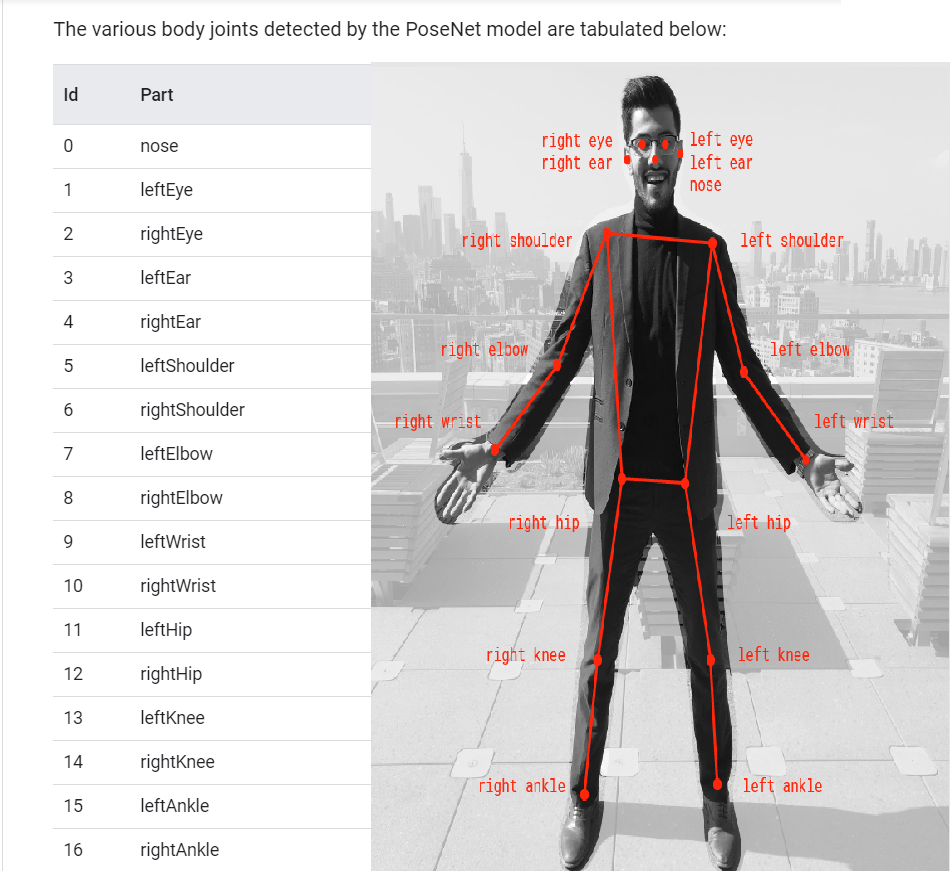

<h3>references:-</h3>
1. bogpost1: https://www.tensorflow.org/lite/examples/pose_estimation/overview <br>
2. bogpost2: https://medium.com/roonyx/pose-estimation-and-matching-with-tensorflow-lite-posenet-model-ea2e9249abbd <br>
2. posenet paper: https://arxiv.org/abs/1803.08225 <br>
3. code referance: https://colab.research.google.com/drive/1xRb4e52oBXwtvivdZ5Fn8dGJ1jZ-CuUYa <br>

In [ ]:
def parse_output(heatmap_data,offset_data, threshold):

    '''
    Input:
        heatmap_data - hetmaps for an image. Three dimension array
        offset_data - offset vectors for an image. Three dimension array
        threshold - probability threshold for the keypoints. Scalar value
    Output:
        array with coordinates of the keypoints and flags for those that have
        low probability
    '''

    joint_num = heatmap_data.shape[-1]
    pose_kps = np.zeros((joint_num,3), np.uint32)

    for i in range(heatmap_data.shape[-1]):

        joint_heatmap = heatmap_data[...,i]
        max_val_pos = np.squeeze(np.argwhere(joint_heatmap==np.max(joint_heatmap))[0])
        remap_pos = np.array(max_val_pos/8*257,dtype=np.int32)
        pose_kps[i,0] = int(remap_pos[0] + offset_data[max_val_pos[0],max_val_pos[1],i])
        pose_kps[i,1] = int(remap_pos[1] + offset_data[max_val_pos[0],max_val_pos[1],i+joint_num])
        max_prob = np.max(joint_heatmap)

        if max_prob > threshold:
            if pose_kps[i,0] < 257 and pose_kps[i,1] < 257:
                pose_kps[i,2] = 1

    return pose_kps

In [ ]:
def draw_kps(show_img,kps, ratio=None):
    for i in range(kps.shape[0]):
        if kps[i,2]:
            if isinstance(ratio, tuple):
                cv.circle(show_img,(int(round(kps[i,1]*ratio[1])),int(round(kps[i,0]*ratio[0]))),2,(0,255,0),round(int(1*ratio[1])))
                continue
            cv.circle(show_img,(kps[i,1],kps[i,0]),2,(0,255,255),-1)
    return show_img

In [ ]:
def model_setup():
    path = "Models/posenet_mobilenet_v1_100_257x257_multi_kpt_stripped.tflite"
    interpreter = tf.lite.Interpreter(model_path=path)
    interpreter.allocate_tensors()
    return interpreter
interpreter=model_setup()

In [ ]:
def get_keypoint_img(img_path,interpreter,draw=True):
    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()
    height = input_details[0]['shape'][1]
    width = input_details[0]['shape'][2] 
    #reading of query image
    template_input = cv.imread(img_path)
    template_input = cv.resize(template_input, (width, height),interpolation = cv.INTER_AREA)
    template_input = np.expand_dims(template_input, axis=0)
    # check the type of the input tensor
    if input_details[0]['dtype'] == np.float32:
        # Brings input values to range from 0 to 1
        template_input = (np.float32(template_input)/ 255.0)
    # Process template image
    # Sets the value of the input tensor
    interpreter.set_tensor(input_details[0]['index'], template_input)
    # Runs the computation
    interpreter.invoke()
    # Extract output data from the interpreter
    template_heatmaps = interpreter.get_tensor(output_details[0]['index'])
    template_offsets = interpreter.get_tensor(output_details[1]['index'])
    # Getting rid of the extra dimension
    template_heatmaps = np.squeeze(template_heatmaps)
    template_offsets = np.squeeze(template_offsets)
    #print("template_heatmaps' shape:", template_heatmaps.shape)
    #print("template_offsets' shape:", template_offsets.shape)
    template_show = np.squeeze((template_input.copy()))
    template_show = np.array(template_show*255,np.uint8)
    template_kps = parse_output(template_heatmaps,template_offsets,0.3)
    if draw==True:
        #plt.imshow(draw_kps(template_show,template_kps),cmap ='jet')
        plt.imshow(cv.cvtColor(draw_kps(template_show,template_kps), cv.COLOR_BGR2RGB))
    return template_kps

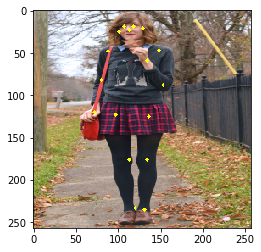

In [ ]:
template_kps=get_keypoint_img("Dataset/street2shop/images/28.jpg",interpreter)

In [ ]:
def check_full_shot(img_path,interpreter,show=True):
    template_kps=get_keypoint_img(img_path,interpreter,draw=show)
    if (template_kps[0][2]==1) and ((template_kps[1][2] or template_kps[2][2]) ==1) and ((template_kps[11][2] or template_kps[12][2]) ==1) and ((template_kps[15][2] or template_kps[16][2]) ==1):
        return True
    else:
        return False

True

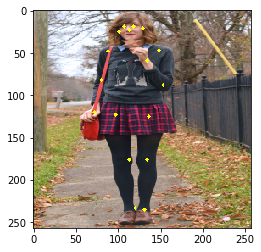

In [ ]:
check_full_shot("Dataset/street2shop/images/28.jpg",interpreter,show=True)

In [ ]:
img_path='Dataset/street2shop/images/'
files=os.listdir(img_path)
    try:
        if check_full_shot(img_path+i,interpreter,show=False):
            shutil.copy(img_path+i, 'Dataset/street2shop/full_pose_images')
    except:
        continue

<h3>Sample fullshot images

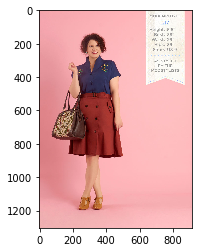

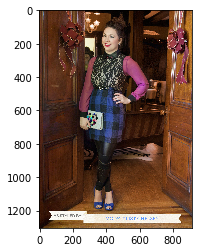

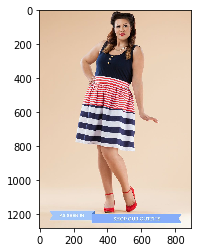

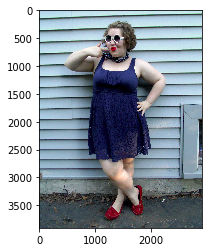

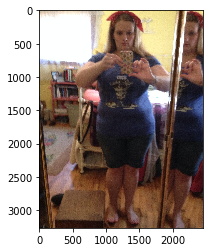

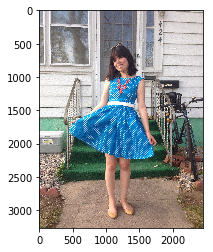

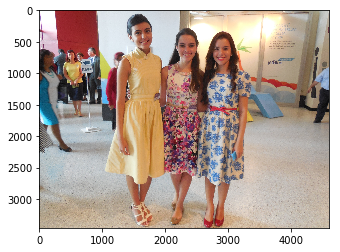

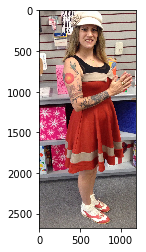

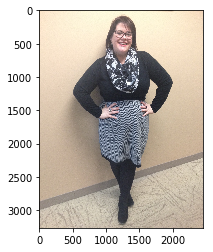

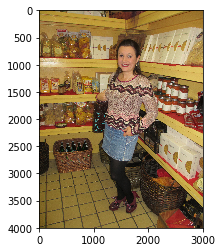

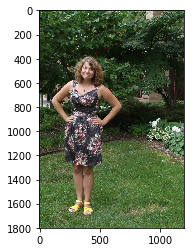

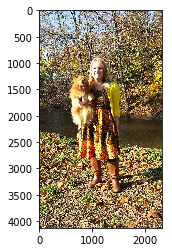

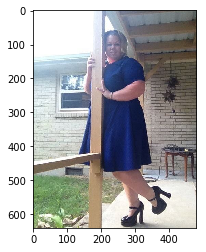

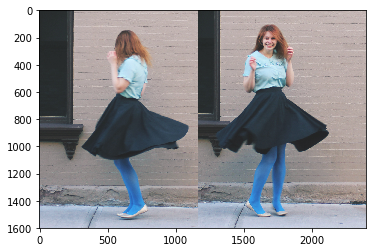

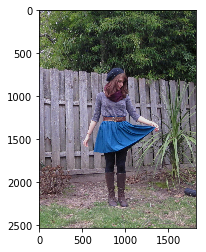

In [ ]:
img_path='Dataset/street2shop/full_pose_images/'
files=os.listdir(img_path)
def draw(img_path):
    figure, ax = plt.subplots(1)
    img_name=random.choice(img_path)
    img = cv.imread(img_path)
    img= cv.cvtColor(img, cv.COLOR_BGR2RGB)
    ax.imshow(img)
    plt.show()
for i in range(15):
    path=img_path+random.choice(files)
    draw(path)

<h3>Conclusion:-

1. Using the keypoint predicted by posenet model we are able to get the full-pose-image.
2. from the above sample full pose images we can see that we can get multiple persons also in an image